In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('forecasting-passenger-traffic-testcases\input\input00.txt', sep='\t', lineterminator='\n')
df.columns = ['passengers']
month_num = list(range(1, df.shape[0]+1))
df.index = month_num

In [3]:
df.head()

,passengers
1,1226800
2,926891
3,782725
4,1023038
5,1126293


In [4]:
df.describe()

,passengers
count,6.000000e+01
mean,9.690419e+05
std,2.197623e+05
min,5.107860e+05
25%,8.004328e+05
50%,1.007325e+06
75%,1.131619e+06
max,1.461091e+06


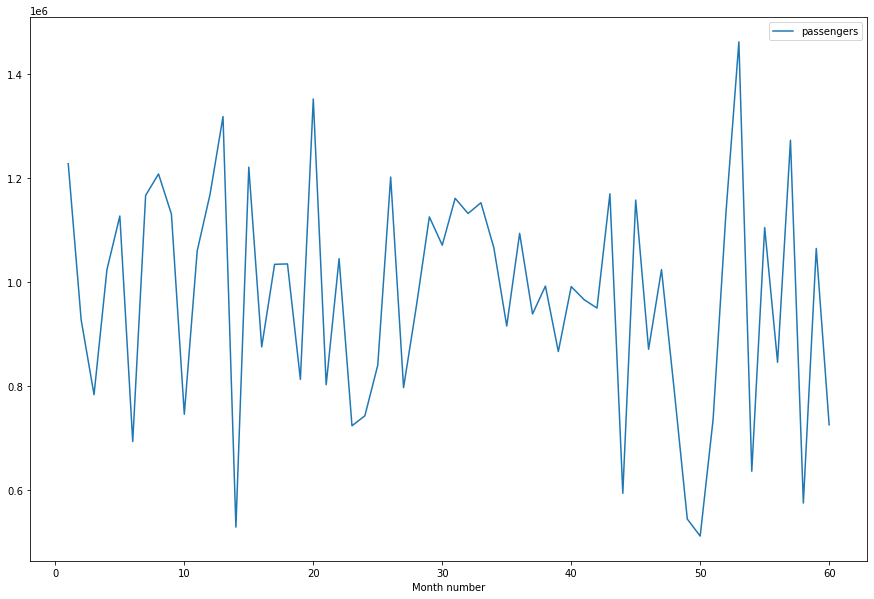

In [5]:
df.plot(figsize=(15,10))
plt.xlabel('Month number')
plt.show()

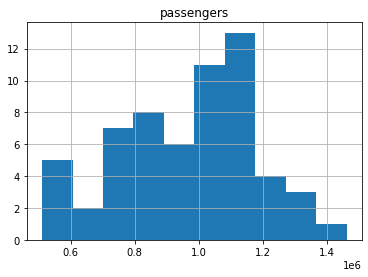

In [6]:
df.hist()
plt.show()

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

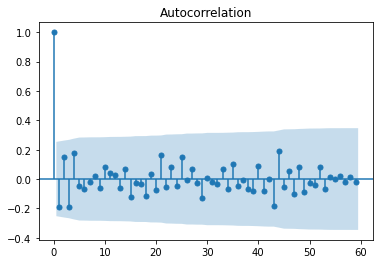

In [8]:
plot_acf(df, lags=59)
plt.show()

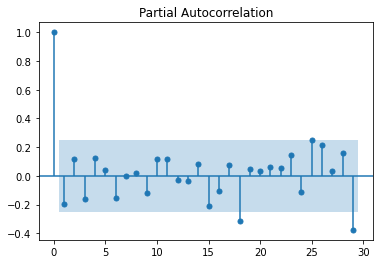

In [9]:
plot_pacf(df, lags=29)
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller

adfuller_test = adfuller(df)
print('ADF Statistic: %f' % adfuller_test[0])
print('p-value: %f' % adfuller_test[1])
print('Critical Values:')
for key, value in adfuller_test[4].items():
    print('\t%s: %.3f' % (key, value))
if adfuller_test[1] <= 0.05:
    print('p-value <= 0.05. The series is stationary')
else:
    print('p-value > 0.05. The series is non-stationary')

ADF Statistic: -4.751331
p-value: 0.000067
Critical Values:
	1%: -3.551
	5%: -2.914
	10%: -2.595
p-value <= 0.05. The series is stationary


In [45]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [46]:
model = pm.auto_arima(df, 
                      start_p=0, 
                      start_q=0,
                      d=0,
                      max_p=5,
                      max_q=5,
                      D=0,
                      information_criterion='bic', 
                      trace=True)

Performing stepwise search to minimize bic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=1653.489, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=1655.332, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=1655.822, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=1831.415, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=1658.989, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.088 seconds


In [57]:
model = ARIMA(df, order=(5,0,3)).fit()

C:\Users\henri\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\henri\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

In [58]:
res = model.resid

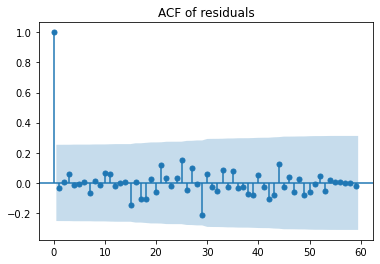

In [59]:
plot_acf(res, lags=59, title='ACF of residuals')
plt.show()

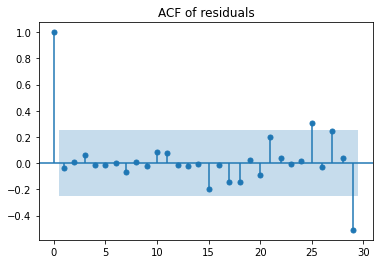

In [60]:
plot_pacf(res, lags=29, title='ACF of residuals')
plt.show()

In [61]:
df_test = pd.read_csv('forecasting-passenger-traffic-testcases\output\output00.txt', sep='\t', lineterminator='\n')
df_test.columns = ['real']

In [62]:
df_test

,real
0,1312558
1,1501793
2,1388316
3,1325942
4,1410769
5,687396
6,1493945
7,1161128
8,590382
9,1082215


In [63]:
forecast, stderr, conf_int = model.forecast(11)

In [64]:
df_test['predicted'] = forecast

<AxesSubplot:>

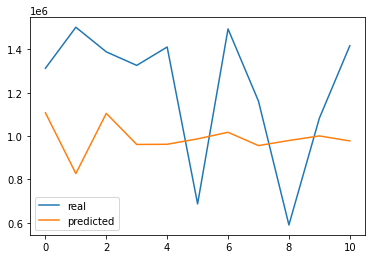

In [65]:
df_test.plot()

In [23]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [24]:
mse = mean_squared_error(df_test['real'].tolist(),df_test['predicted'].tolist())
rmse = sqrt(mse)
rmse

384509.994059257

In [25]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [26]:
mean_absolute_percentage_error(df_test['real'].tolist(),df_test['predicted'].tolist())

31.434908030509906

In [27]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [28]:
model_HWES = ExponentialSmoothing(df).fit()

C:\Users\henri\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\henri\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\henri\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [29]:
yhat_HWES = model_HWES.forecast(11)

C:\Users\henri\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [30]:
yhat_HWES

60    910138.405573
61    910138.405573
62    910138.405573
63    910138.405573
64    910138.405573
65    910138.405573
66    910138.405573
67    910138.405573
68    910138.405573
69    910138.405573
70    910138.405573
dtype: float64

In [31]:
df_test_HWES = pd.read_csv('forecasting-passenger-traffic-testcases\output\output00.txt', sep='\t', lineterminator='\n')
df_test_HWES.columns = ['real']

In [32]:
df_test_HWES['predicted'] = yhat_HWES.tolist()

In [33]:
df_test_HWES

,real,predicted
0,1312558,910138.405573
1,1501793,910138.405573
2,1388316,910138.405573
3,1325942,910138.405573
4,1410769,910138.405573
5,687396,910138.405573
6,1493945,910138.405573
7,1161128,910138.405573
8,590382,910138.405573
9,1082215,910138.405573


<AxesSubplot:>

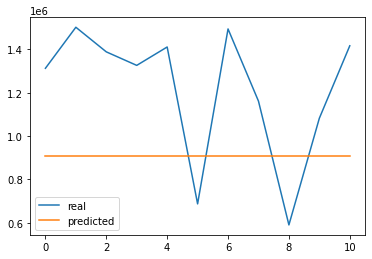

In [34]:
df_test_HWES.plot()